In [1]:
import os
from pathlib import Path
import pymysql
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Kkma
import pandas as pd
import ast
from PIL import Image
from wordcloud import WordCloud

DATABASE_NAME = "chats"
HOST_NAME = "localhost"
USER_ID = "root"
USER_PASSWORD = "rootPW1!"
CHARSET = "utf8"
TXT_FOLDER_PATH = "chats"

In [2]:
conn = pymysql.connect(host=HOST_NAME, user=USER_ID, passwd=USER_PASSWORD, charset=CHARSET)
cursor = conn.cursor()

In [3]:
sql = 'USE %s ;'%DATABASE_NAME
cursor.execute(sql)
conn.commit()

In [4]:
sql = 'SELECT * FROM indexes;'
cursor.execute(sql)
conn.commit()
rows=cursor.fetchall()

In [5]:
ls=[]
for row in rows :
    if row[1]<10:
        table_name = str(row[0])+'0'+str(row[1])
    else:
        table_name = str(row[0])+str(row[1])
    sql='SELECT * FROM %schats;' %table_name
    cursor.execute(sql)
    conn.commit()
    results = cursor.fetchall()
    for result in results:
#         print(result)
        item = [result[0], result[0].year, result[0].month, result[0].day, result[0].hour, result[0].minute, result[1], result[2]]
        ls.append(item)

In [6]:
df_origin = pd.DataFrame(ls,columns=['time','year','month','day','hour','minute','sender','message'])

In [7]:
def write_messages_by_sender(sender):
    file_name='messages_by_'+sender+"_"+str(year)+'.txt'
    with open (file_name,'w') as f :
        f.write('\n'.join(df_origin[df_origin['sender']==sender]['message']))

In [8]:
def write_messages_by_sender_year(sender,year):
    file_name='messages_by_'+sender+"_"+str(year)+'.csv'
#     with open (file_name,'w') as f :
    df_origin[(df_origin['sender']==sender) & (df_origin['year']==year)]['message'].to_c

In [9]:
def write_csv_by_year(year):
    file_name='messages_at_'+str(year)+'.csv'
    df_origin[(df_origin['year']==year)].to_csv(file_name,index=False,encoding='utf-8-sig')

In [10]:
def write_csv_all():
    file_name='messages_all.csv'
    df_origin.to_csv(file_name,index=False,encoding='utf-8-sig')

In [ ]:
write_csv_by_year(2021)
write_csv_by_year(2019)
write_csv_by_year(2018)
write_csv_by_year(2020)

In [13]:
def get_noun(msg_txt):
    kkma = Kkma()
    nouns = list()
    pattern = re.compile("[ㄱ-ㅎㅏ-ㅣ]+")
    msg_txt = re.sub(pattern, "", msg_txt).strip()

    if len(msg_txt) > 1 and len(msg_txt)<50:
        pos = kkma.pos(msg_txt)
        for keyword, type in pos:
            # 고유명사 또는 보통명사
            if (type == "NNG" or type == "NNP") and len(keyword)>1:
                nouns.append(keyword)
#         print(msg_txt, "->", nouns)

    return nouns

In [14]:
def get_csv_name(year):
    return 'messages_at_'+str(year)+'.csv'

In [15]:
def get_csv_token_name(year):
    return 'tokens_at_'+str(year)+'.csv'

In [16]:
# csv_21 = pd.read_csv(get_csv_name(2021))
# csv_21['token']=csv_21['message'].apply(lambda x: get_noun(x))
# csv_21=csv_21.dropna()
# csv_21.to_csv(get_csv_token_name(2021), index=False,encoding='utf-8-sig')

In [17]:
def make_tokens_from_msgs(years):
    for year in years :
        c = pd.read_csv(get_csv_name(year))
        c['token']=c['message'].apply(lambda x: get_noun(x))
        c=c.dropna()
        c.to_csv(get_csv_token_name(year), index=False,encoding='utf-8-sig')
        print(str(year)+" finished!")

In [ ]:
make_tokens_from_msgs([2018,2019,2020,2021])

In [40]:
def draw_wordcloud(kkma_result,sender='',year=0):
    # List로 되어있는 열을 Row 단위로 분리
    if sender=='':
        tokens = pd.DataFrame(kkma_result["token"].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        tokens = pd.DataFrame(kkma_result[kkma_result['sender']==sender]["token"].apply(lambda x: ast.literal_eval(x)).tolist())     
    tokens["Date"] = kkma_result["time"]
    tokens["Sender"] = kkma_result["sender"]
    tokens["Message"] = kkma_result["message"]
    tokens = tokens.set_index(["Date", "Sender", "Message"])
    tokens = tokens.T.unstack().dropna().reset_index()
    tokens.columns = ["Date", "Speaker", "sntc", "index", "token"]
#     # 빈도수 집계
    summary = tokens.groupby(["token"])["index"].count().reset_index()
    summary = summary.sort_values(["index"], ascending=[False]).reset_index(drop=True)

    except_words=['내가','조아','이번','마자','나도','거지','구래','니야','무엇','정도','황의','진이','하다','지금','자소','생각','이상','할거','오늘','내일','사람']
   # 특정 단어 필터링
    summary = summary[summary["token"].apply(lambda x: x not in except_words)]
    summary = summary[summary["token"].apply(lambda x: len(x) > 1)]
    summary_top = summary[:100]


# 워드클라우드 생성
    wc = WordCloud(background_color='white', width=2500, height=2000, font_path='./font/NanumGothic.ttf').generate(" ".join(summary_top["token"]))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(sender+'`s Cloud('+str(year)+")")
    plt.show()

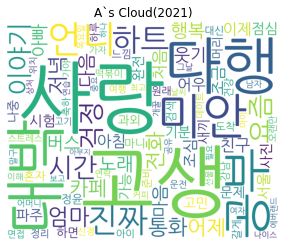

In [41]:
csv=pd.read_csv(get_csv_token_name(2021))
draw_wordcloud(csv,'A',2021)

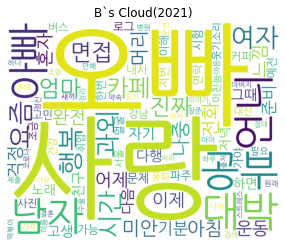

In [42]:
csv=pd.read_csv(get_csv_token_name(2021))
draw_wordcloud(csv,'B',2021)

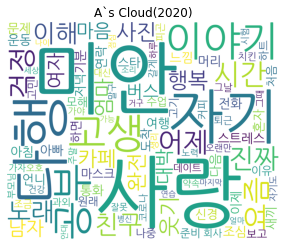

In [43]:
csv=pd.read_csv(get_csv_token_name(2020))
draw_wordcloud(csv,'A',2020)

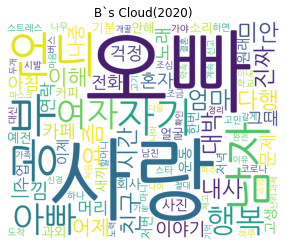

In [44]:
csv=pd.read_csv(get_csv_token_name(2020))
draw_wordcloud(csv,'B',2020)

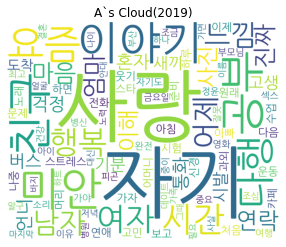

In [45]:
csv=pd.read_csv(get_csv_token_name(2019))
draw_wordcloud(csv,'A',2019)

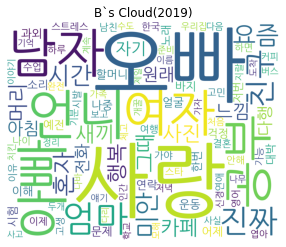

In [46]:
csv=pd.read_csv(get_csv_token_name(2019))
draw_wordcloud(csv,'B',2019)

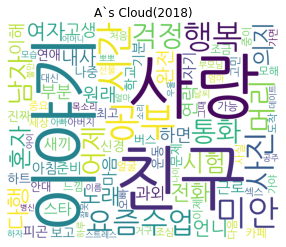

In [47]:
csv=pd.read_csv(get_csv_token_name(2018))
draw_wordcloud(csv,'A',2018)

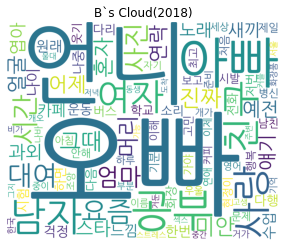

In [48]:
csv=pd.read_csv(get_csv_token_name(2018))
draw_wordcloud(csv,'B',2018)